In [34]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# tensorflow/keras libraries
import keras
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
images_home = "../xray-classification/chest_xray_images/"
train_files = images_home+"train/"
test_files = images_home+"test/"
val_files = images_home+"val/"

In [3]:
print(os.listdir(train_files))

['NORMAL', 'PNEUMONIA']


In [4]:
train_norm = train_files+"NORMAL/"
train_sick = train_files+"PNEUMONIA/"

In [5]:
print(len(os.listdir(train_norm)))
print(len(os.listdir(train_sick)))

1342
3876


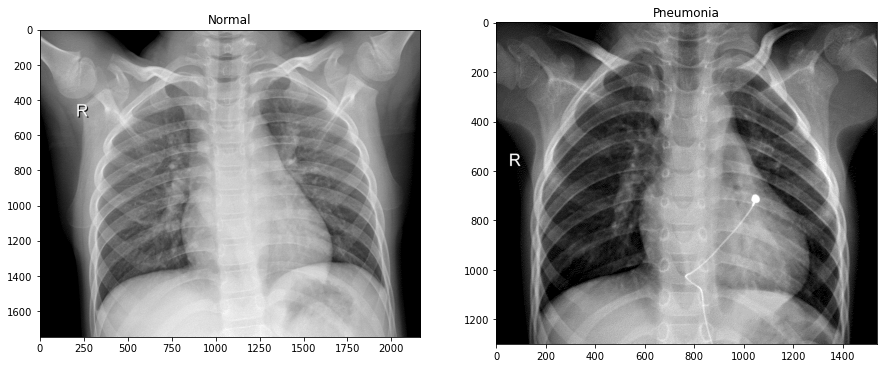

In [6]:
norm_pic_file = os.listdir(train_norm)[40]
sick_pic_file = os.listdir(train_sick)[40]

norm_pic_full_filname = train_norm + norm_pic_file
sick_pic_full_filname = train_sick + sick_pic_file

pic_norm = Image.open(norm_pic_full_filname).convert('1')
pic_sick = Image.open(sick_pic_full_filname).convert('1')

f = plt.figure(figsize=(15,15))
a_norm = f.add_subplot(1,2,1)
img_plot = plt.imshow(pic_norm)
a_norm.set_title("Normal")

a_sick = f.add_subplot(1,2,2)
img_plot = plt.imshow(pic_sick)
a_sick.set_title("Pneumonia");

In [7]:
model = Sequential()

model.add(
    Conv2D(
        32, 
        (3, 3), 
        activation='relu', 
        input_shape=(64,64,3),
        padding='same')
    )
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation='softmax', units = 2))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1843328   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
#model.fit(train_images, train_labels, epochs=2, batch_size=64)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(train_files,
                                  target_size = (64,64),
                                  batch_size = 32,
                                  class_mode = 'binary');


test_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = test_datagen.flow_from_directory(val_files,
                                  target_size = (64,64),
                                  batch_size = 32,
                                  class_mode = 'binary');

test_generator = test_datagen.flow_from_directory(test_files,
                                  target_size = (64,64),
                                  batch_size = 32,
                                  class_mode = 'binary');

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
cnn_model = model.fit(train_generator,
                         steps_per_epoch = 128,
                         epochs = 6,
                         validation_data = validation_generator,
                         validation_steps = 16)

Epoch 1/6
128/128 [==============================] - 41s 317ms/step - loss: 0.1496 - accuracy: 0.9414 - val_loss: 0.4093 - val_accuracy: 0.6875
Epoch 2/6
128/128 [==============================] - 40s 313ms/step - loss: 0.1275 - accuracy: 0.9541
Epoch 3/6
128/128 [==============================] - 40s 314ms/step - loss: 0.1218 - accuracy: 0.9551
Epoch 4/6
128/128 [==============================] - 40s 313ms/step - loss: 0.1323 - accuracy: 0.9514
Epoch 5/6
128/128 [==============================] - 40s 310ms/step - loss: 0.1235 - accuracy: 0.9526
Epoch 6/6
128/128 [==============================] - 40s 311ms/step - loss: 0.1223 - accuracy: 0.9541


In [28]:
test_acc = model.evaluate(test_generator, steps= 20)

20/20 [==============================] - 5s 238ms/step - loss: 0.5602 - accuracy: 0.8141


In [19]:
print('The testing accuracy is :',test_acc[1]*100, '%')

The testing accuracy is : 81.41025900840759 %
